In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
import os

In [2]:
root_path = os.path.join(os.environ['HOME'], 'projects/tuplex-public/tuplex/cmake-build-debug/dist/bin')
path = root_path + '/aws_job.json'

In [3]:
# !cp /Users/leonhards/projects/tuplex-public/tuplex/cmake-build-debug/dist/bin/aws_job.json{,.backup}

In [4]:
os.path.isfile(path)

True

In [7]:
!open /Users/leonhards/projects/tuplex-public/tuplex/cmake-build-debug/dist/bin/

In [11]:
with open(path, 'r') as fp:
    content = fp.read()

In [12]:
content[81125-100:81125+100]

''

In [13]:
with open(path, 'r') as fp:
    data = json.load(fp)

In [14]:
data

{'stageStartTimestamp': 1643700177899169000,
 'stageEndTimestamp': 1643700210499014000,
 'tasks': [{'container': {'reused': True,
    'requestId': '8d78d5c0-735e-4ed5-828d-237451551aea',
    'uuid': '87964fb3-a952-47ed-93d7-6cc4301c2068',
    'msRemaining': 568826,
    'requestsServed': 3,
    'startTimestamp': 1643699652259668447,
    'deadlineTimestamp': 1643700778858000000},
   'invoked_containers': [{'reused': False,
     'requestId': '63f28bf0-94ec-46b8-b52e-a9f2e15d2681',
     'uuid': 'ab447a49-f316-4371-b5b3-e699586636f8',
     'msRemaining': 597399,
     'requestsServed': 1,
     'startTimestamp': 1643700184844568692,
     'deadlineTimestamp': 1643700784889000000},
    {'reused': False,
     'requestId': '542d9726-9593-428a-ac51-14446aa69783',
     'uuid': 'e5560aeb-ba76-4fc2-9deb-8f6258ff554a',
     'msRemaining': 596791,
     'requestsServed': 1,
     'startTimestamp': 1643700186066979409,
     'deadlineTimestamp': 1643700786103000000},
    {'reused': True,
     'requestId': 

In [29]:
data['tasks'][0]['invoked_requests']

[]

In [15]:
# analyze invocations with start/end
# -> want to add request start & request end in absolute times!
# --> these values should be filled in by the caller!

In [16]:
rows = []

global_start = data['stageStartTimestamp'] / 1e9

job_duration = data['stageEndTimestamp'] / 1e9 - global_start

def row_from_container(task):
    start_ts = task['startTimestamp'] / 1e9
    dead_ts = task['deadlineTimestamp'] / 1e9
    remaining_s = task['msRemaining'] / 1000.0
    end_ts = dead_ts - remaining_s
    
    duration = end_ts - start_ts
    t = dead_ts - start_ts
    
    row = {'start' : start_ts - global_start,
           'end' : end_ts - global_start,
           'duration' : duration,
           'uuid' : task['uuid']}
    return row


# add the first invoking container!
row = row_from_container(data['tasks'][0]['container'])
# row['start'] += global_start
# row['end'] += global_start
rows.append(row)
for c in data['tasks'][0]['invoked_containers']:
    row = row_from_container(c)
    rows.append(row)

In [17]:
job_duration

32.59984493255615

In [18]:
rows[0]

{'start': -525.6395003795624,
 'end': 32.13283085823059,
 'duration': 557.772331237793,
 'uuid': '87964fb3-a952-47ed-93d7-6cc4301c2068'}

In [19]:
df = pd.DataFrame(rows)#.reset_index().rename(columns={'index' : 'request'})

In [20]:
# group after uuid and get from there number (asc after start!)
df = df.sort_values(by=['end'])

In [21]:
len(df['uuid'].unique())

198

In [22]:
df.sort_values(by=['start']).head()

,start,end,duration,uuid
61,-527.173372,8.121831,535.295203,c4a6398c-2a50-4a4f-828d-60e2c10edf3e
72,-527.153701,4.223831,531.377532,33f1ea7e-0167-49e2-895b-780f53dd6e19
136,-526.869444,5.363831,532.233275,0944171c-70cf-432b-a7ec-a2e5c0a7a331
51,-526.712817,7.932831,534.645648,737f0507-ef43-4c71-9b3b-1de36288fd5a
85,-526.660302,7.876831,534.537133,0ea4ef0a-7dc4-48eb-9d81-22a299b248a0


In [23]:
# this is information regarding containers
# => want to know something about requests though!

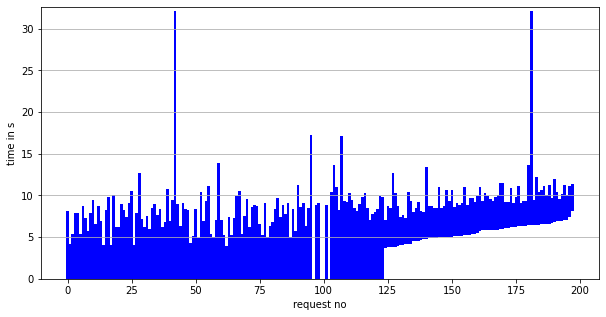

In [25]:
plt.figure(figsize=(10, 5))

pos = 0
for idx, row in df.sort_values(by=['start']).iterrows():
    plt.bar(pos, row['duration'], 1, bottom=row['start'], color='blue')
    pos += 1
# plt.xticks([0, 1, 2, 3])
plt.ylim(0, job_duration)
# plt.x
plt.ylabel('time in s')
plt.xlabel('request no')
plt.grid(axis='y')

In [82]:
data['tasks'][0]['invoked_containers']

[{'reused': False,
  'requestId': 'b8905283-be18-4727-b914-9b4c23f30b61',
  'uuid': '8397ce4a-0279-4350-a008-eb818eb1f464',
  'msRemaining': 597987,
  'requestsServed': 1,
  'startTimestamp': 1643349680809836438,
  'deadlineTimestamp': 1643350280846000000},
 {'reused': False,
  'requestId': 'a06206e9-469e-413c-9187-9fb4d061fb3f',
  'uuid': '44629c20-e17c-4032-882e-b6e98286ffc4',
  'msRemaining': 597879,
  'requestsServed': 1,
  'startTimestamp': 1643349680961759223,
  'deadlineTimestamp': 1643350280998000000},
 {'reused': False,
  'requestId': '3104dc70-3cc0-4c7d-9f96-e05102b8b473',
  'uuid': '76a84344-931f-44c7-87da-20c7040748d3',
  'msRemaining': 598131,
  'requestsServed': 1,
  'startTimestamp': 1643349680923476145,
  'deadlineTimestamp': 1643350280959000000}]

In [27]:
import datetime

In [ ]:
stageStart

In [28]:
datetime.datetime.fromtimestamp(1643339402105915345)

OSError: [Errno 22] Invalid argument

In [30]:
help(datetime.datetime.fromtimestamp)

Help on built-in function fromtimestamp:

fromtimestamp(...) method of builtins.type instance
    timestamp[, tz] -> tz's local time from POSIX timestamp.



In [37]:
import time
datetime.datetime.fromtimestamp(time.time())

datetime.datetime(2022, 1, 27, 23, 50, 57, 880027)

In [47]:
datetime.datetime.fromtimestamp(1643339404174495380 / 1e9)

datetime.datetime(2022, 1, 27, 22, 10, 4, 174495)

In [49]:
datetime.datetime.fromtimestamp(391858287253828 / 1e9)

datetime.datetime(1970, 1, 5, 7, 50, 58, 287254)